In [1]:
%matplotlib inline
import yt
import yt.fields.vector_operations
from yt.units import dimensions, kboltz, mp
import os, sys, glob, errno
import matplotlib as mpl
#mpl.use("agg")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import Locator
from scipy.interpolate import spline
import operator
import h5py
import mag_initialize as m


mu = 0.588
mu_e = 1.14
gamma = 5/3

a=0

def get_units(L):
    temp_str = str(L[-1:])
    k = temp_str.rfind("]") + 2
    return temp_str[k:]

def density(filename,groupname):
    return m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/density_mean"%groupname)[a:]  

def kT(filename,groupname):
    return m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/kT_mean"%groupname)[a:] 

# radial 
def velocity_r_variance(filename,groupname):
    v_r_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_radius_stddev"%groupname)[a:] 
    return v_r_stddev**2

# tangential
def velocity_t_variance(filename,groupname):
    v_theta_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_theta_stddev"%groupname)[a:] 
    v_phi_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_phi_stddev"%groupname)[a:]  
    return v_theta_stddev**2+v_phi_stddev**2

# filename is HDF5 file, groupname is 0500_profiles
def velocity_variance(filename,groupname):
    #v_r_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_radius_stddev"%groupname)
    #v_t_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_theta_stddev"%groupname)
    #v_p_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_phi_stddev"%groupname)    
    return velocity_r_variance(filename,groupname)+velocity_t_variance(filename,groupname)

# filename is HDF5 file, groupname is 0500_profiles
def mag_field_variance(filename,groupname):
    B_r_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_radius_stddev"%groupname)[a:] 
    B_t_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_theta_stddev"%groupname)[a:] 
    B_p_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_phi_stddev"%groupname)[a:]     
    return B_r_stddev**2+B_t_stddev**2+B_p_stddev**2

# mean squared
def velocity_mean_sq(filename,groupname):
    v_r_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_radius_mean"%groupname)[a:] 
    v_t_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_theta_mean"%groupname)[a:] 
    v_p_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_phi_mean"%groupname)[a:]     
    return v_r_mean**2+v_t_mean**2+v_p_mean**2

# mean squared
def mag_field_mean_sq(filename,groupname):
    B_r_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_radius_mean"%groupname)[a:] 
    B_t_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_theta_mean"%groupname)[a:] 
    B_p_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_phi_mean"%groupname)[a:]     
    return B_r_mean**2+B_t_mean**2+B_p_mean**2

# sound speed sq
def c_s_sq(filename,groupname):
    return gamma*kT(filename,groupname)/(mu*mp)

# Alfven speed sq
def v_A_sq(filename,groupname):
    return (mag_field_variance(filename,groupname)+mag_field_mean_sq(filename,groupname))/(4*np.pi*density(filename,groupname))
    
def n_e(filename,groupname):
    return density(filename,groupname)/(mu_e*mp)
    
def S(filename,groupname):
    return kT(filename,groupname)/(n_e(filename,groupname))**(2/3)

SIM_TYPE11 = "1to1_b0"
SIM_TYPE12 = "1to1_b0.5"
SIM_TYPE13 = "1to1_b1"
SIM_TYPE21 = "1to3_b0"
SIM_TYPE22 = "1to3_b0.5"
SIM_TYPE23 = "1to3_b1"
SIM_TYPE31 = "1to10_b0"
SIM_TYPE32 = "1to10_b0.5"
SIM_TYPE33 = "1to10_b1"

SIM_TYPE11_mag = "1to1_b0"+"_mag.hdf5"
SIM_TYPE12_mag = "1to1_b0.5"+"_mag.hdf5"
SIM_TYPE13_mag = "1to1_b1"+"_mag.hdf5"

SIM_TYPE21_mag = "1to3_b0"+"_mag.hdf5"
SIM_TYPE22_mag = "1to3_b0.5"+"_mag.hdf5"
SIM_TYPE23_mag = "1to3_b1"+"_mag.hdf5"

SIM_TYPE31_mag = "1to10_b0"+"_mag.hdf5"
SIM_TYPE32_mag = "1to10_b0.5"+"_mag.hdf5"
SIM_TYPE33_mag = "1to10_b1"+"_mag.hdf5"

SIM_TYPE11_no_mag = "1to1_b0"+"_no_mag.hdf5"
SIM_TYPE12_no_mag = "1to1_b0.5"+"_no_mag.hdf5"
SIM_TYPE13_no_mag = "1to1_b1"+"_no_mag.hdf5"

SIM_TYPE21_no_mag = "1to3_b0"+"_no_mag.hdf5"
SIM_TYPE22_no_mag = "1to3_b0.5"+"_no_mag.hdf5"
SIM_TYPE23_no_mag = "1to3_b1"+"_no_mag.hdf5"

SIM_TYPE31_no_mag = "1to10_b0"+"_no_mag.hdf5"
SIM_TYPE32_no_mag = "1to10_b0.5"+"_no_mag.hdf5"
SIM_TYPE33_no_mag = "1to10_b1"+"_no_mag.hdf5"

/data/odin/BACKUPS/jzuhone/miniconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/home/jzuhone/Source/yt/yt/fields/local_fields.py:46: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  warnings.warn("Because 'sampling_type' not specified, yt will "


Beginning time series for mass, KE, IE, ME


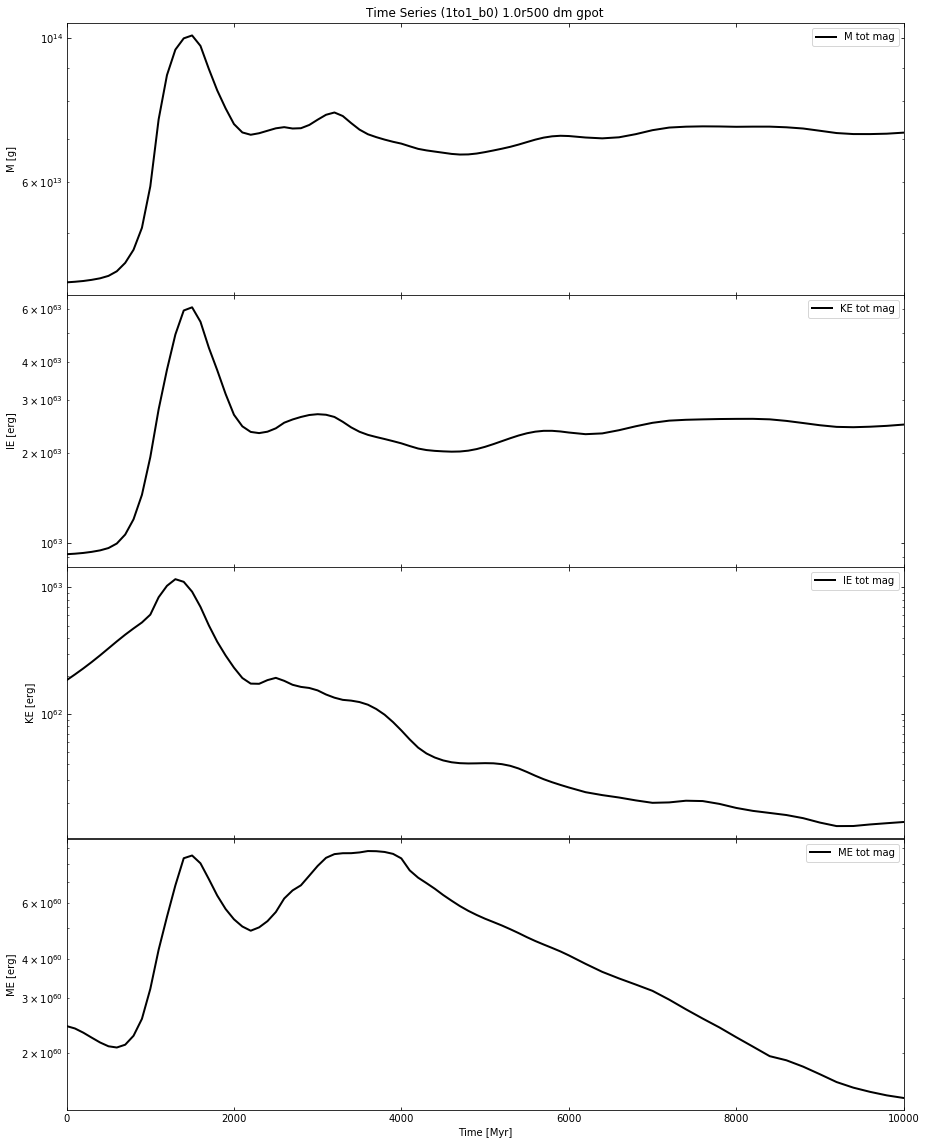

Finishing time series for mass, KE, IE, ME


In [4]:
f_mag = h5py.File(SIM_TYPE11_mag, 'r')
#f_no_mag = h5py.File(SIM_TYPE11_no_mag, 'r')
time = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/time"%"time_series_1.0r_500_part_gpm")[a:].in_units('Myr')
#time1to1nomag = m.yt.YTArray.from_hdf5(SIM_TYPE11_no_mag, dataset_name="/%s/time"%"time_series_1.0r_500_part_gpm")[a:].in_units('Myr')


mass_total_mag = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/mass_total"%"time_series_1.0r_500_part_gpm")[a:].in_units('Msun')
internal_energy_total_mag = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/internal_energy_total"%"time_series_1.0r_500_part_gpm")[a:].in_units('erg')
kinetic_energy_total_mag = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/kinetic_energy_total"%"time_series_1.0r_500_part_gpm")[a:].in_units('erg')
magnetic_energy_total_mag = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/magnetic_energy_total"%"time_series_1.0r_500_part_gpm")[a:].in_units('erg')

#mass_total_no_mag = m.yt.YTArray.from_hdf5(SIM_TYPE11_no_mag, dataset_name="/%s/mass_total"%"time_series_1.0r_500_part_gpm")[a:].in_units('Msun')
#internal_energy_total_no_mag = m.yt.YTArray.from_hdf5(SIM_TYPE11_no_mag, dataset_name="/%s/internal_energy_total"%"time_series_1.0r_500_part_gpm")[a:].in_units('erg')
#kinetic_energy_total_no_mag = m.yt.YTArray.from_hdf5(SIM_TYPE11_no_mag, dataset_name="/%s/kinetic_energy_total"%"time_series_1.0r_500_part_gpm")[a:].in_units('erg')

f_mag.close()
#f_no_mag.close()

# plot time series for mass, KE, IE, ME, GPE
#%matplotlib inline
print("Beginning time series for mass, KE, IE, ME")

plt.close('all')
f = plt.figure()
plt.figure(figsize=(15, 20))
plt.subplots_adjust(hspace=0.001)

ax1 = plt.subplot(411)
ax2 = plt.subplot(412, sharex=ax1)
ax3 = plt.subplot(413, sharex=ax1)
ax4 = plt.subplot(414, sharex=ax1)

axes = [ax1, ax2, ax3, ax4]


line_mass_total_mag, =ax1.plot(time, mass_total_mag, 'k', lw=2, label="M tot mag")
line_kinetic_energy_total_mag, =ax3.plot(time, kinetic_energy_total_mag, 'k', lw=2, label="KE tot mag")
line_internal_energy_total_mag, =ax2.plot(time, internal_energy_total_mag, 'k', lw=2, label="IE tot mag")
line_magnetic_energy_total_mag, =ax4.plot(time, magnetic_energy_total_mag, 'k', lw=2, label="ME tot mag")


# line_mass_total_no_mag, =ax1.plot(time1to1nomag, mass_total_no_mag, 'k--', lw=2, label="M tot no mag")
# time1to1nomag=list(time1to1nomag)
# del time1to1nomag[-1]
# line_kinetic_energy_total_no_mag, =ax3.plot(time1to1nomag, kinetic_energy_total_no_mag, 'k--', lw=2, label="KE tot no mag")
# line_internal_energy_total_no_mag, =ax2.plot(time1to1nomag, internal_energy_total_no_mag, 'k--', lw=2, label="IE tot no mag")

# ax1.legend(handles=[line_mass_total_mag,line_mass_total_no_mag], loc=1)
# ax2.legend(handles=[line_kinetic_energy_total_mag,line_kinetic_energy_total_no_mag], loc=1)
# ax3.legend(handles=[line_internal_energy_total_mag,line_internal_energy_total_no_mag], loc=1)
# ax4.legend(handles=[line_magnetic_energy_total_mag], loc=1)
ax1.legend(handles=[line_mass_total_mag], loc=1)
ax2.legend(handles=[line_kinetic_energy_total_mag], loc=1)
ax3.legend(handles=[line_internal_energy_total_mag], loc=1)
ax4.legend(handles=[line_magnetic_energy_total_mag], loc=1)

ax1.set_ylabel('M [g]')
ax2.set_ylabel('IE [erg]')
ax3.set_ylabel('KE [erg]')
ax4.set_ylabel('ME [erg]')

#ax1.set_ylim(2e11,1e13)
#ax2.set_ylim(2e61,1e63)
#ax3.set_ylim(2e58,1e63)
#ax4.set_ylim(1e57,1e61)
            
for ax in axes: 
    ax.set_yscale('log')

    ax.set_xlabel("Time [Myr]")

    ax.set_xlim(0.0, 10000.0)
    
    ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')


ax1.set_title('Time Series (%s) 1.0r500 dm gpot' % '1to1_b0')
xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels() + ax3.get_xticklabels()
plt.setp(xticklabels, visible=False)

#plt.savefig(IMG_DIR+SIM_TYPE+"_time_series_temp.png",bbox_inches='tight')
plt.show()

print("Finishing time series for mass, KE, IE, ME")

Beginning time series for mass, KE, IE, ME


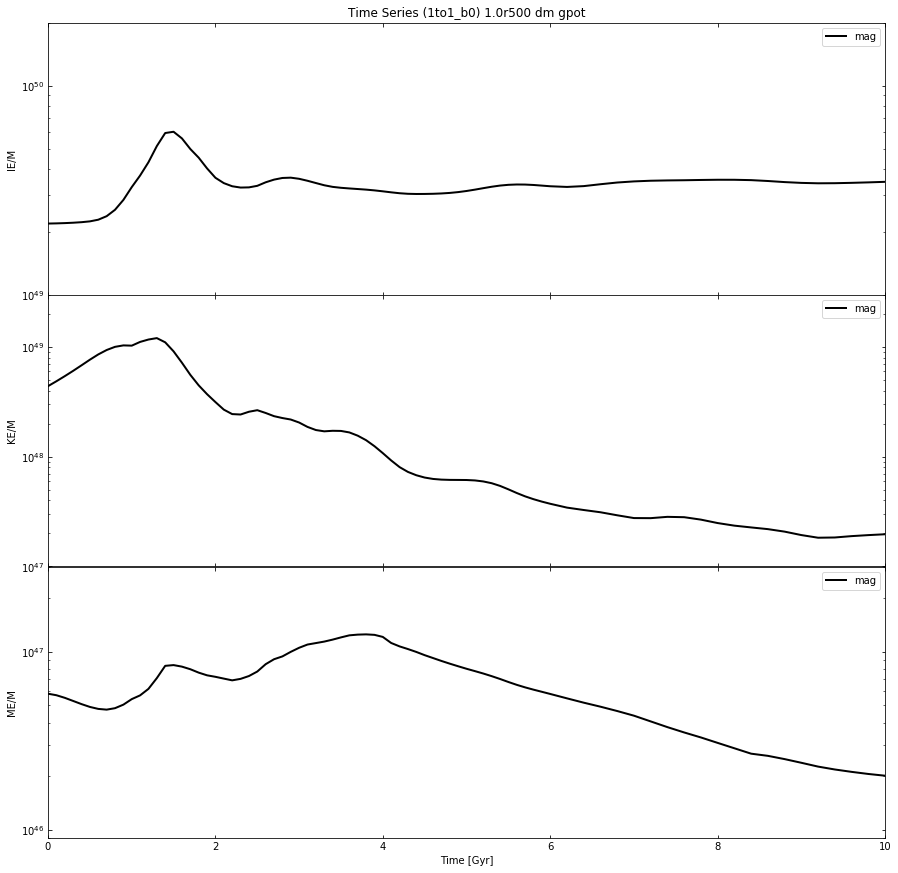

Finishing time series for mass, KE, IE, ME


In [5]:
f_mag = h5py.File(SIM_TYPE11_mag, 'r')
#f_no_mag = h5py.File(SIM_TYPE11_no_mag, 'r')
time = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/time"%"time_series_1.0r_500_part_gpm")[a:].in_units('Myr')
#time1to1nomag = m.yt.YTArray.from_hdf5(SIM_TYPE11_no_mag, dataset_name="/%s/time"%"time_series_1.0r_500_part_gpm")[a:].in_units('Myr')


mass_total_mag = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/mass_total"%"time_series_1.0r_500_part_gpm")[a:].in_units('Msun')
internal_energy_total_mag = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/internal_energy_total"%"time_series_1.0r_500_part_gpm")[a:].in_units('erg')
kinetic_energy_total_mag = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/kinetic_energy_total"%"time_series_1.0r_500_part_gpm")[a:].in_units('erg')
magnetic_energy_total_mag = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/magnetic_energy_total"%"time_series_1.0r_500_part_gpm")[a:].in_units('erg')

# mass_total_no_mag = m.yt.YTArray.from_hdf5(SIM_TYPE11_no_mag, dataset_name="/%s/mass_total"%"time_series_1.0r_500_part_gpm")[a:].in_units('Msun')
# internal_energy_total_no_mag = m.yt.YTArray.from_hdf5(SIM_TYPE11_no_mag, dataset_name="/%s/internal_energy_total"%"time_series_1.0r_500_part_gpm")[a:].in_units('erg')
# kinetic_energy_total_no_mag = m.yt.YTArray.from_hdf5(SIM_TYPE11_no_mag, dataset_name="/%s/kinetic_energy_total"%"time_series_1.0r_500_part_gpm")[a:].in_units('erg')

f_mag.close()
# f_no_mag.close()

# plot time series for mass, KE, IE, ME, GPE
#%matplotlib inline
print("Beginning time series for mass, KE, IE, ME")

plt.close('all')
f = plt.figure()
plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace=0.001)

#ax1 = plt.subplot(411)
ax2 = plt.subplot(311, sharex=ax2)
ax3 = plt.subplot(312, sharex=ax2)
ax4 = plt.subplot(313, sharex=ax2)

axes = [ax1, ax2, ax3, ax4]


#line_mass_total_mag, =ax1.plot(time, mass_total_mag, 'k', lw=2, label="M tot mag")
line_kinetic_energy_total_mag, =ax3.plot(time/1000, kinetic_energy_total_mag/mass_total_mag, 'k', lw=2, label="mag")
line_internal_energy_total_mag, =ax2.plot(time/1000, internal_energy_total_mag/mass_total_mag, 'k', lw=2, label="mag")
line_magnetic_energy_total_mag, =ax4.plot(time/1000, magnetic_energy_total_mag/mass_total_mag, 'k', lw=2, label="mag")


#line_mass_total_no_mag, =ax1.plot(time1to1nomag, mass_total_no_mag, 'k--', lw=2, label="M tot no mag")
# time1to1nomag=list(time1to1nomag)
# del time1to1nomag[-1]
# time1to1nomag=np.array(time1to1nomag)
# mass_total_no_mag=list(mass_total_no_mag)
# del mass_total_no_mag[-1]
# mass_total_no_mag=np.array(mass_total_no_mag)
# line_kinetic_energy_total_no_mag, =ax3.plot(time1to1nomag/1000, kinetic_energy_total_no_mag/mass_total_no_mag, 'k--', lw=2, label="no mag")
# line_internal_energy_total_no_mag, =ax2.plot(time1to1nomag/1000, internal_energy_total_no_mag/mass_total_no_mag, 'k--', lw=2, label="no mag")


# ax2.legend(handles=[line_kinetic_energy_total_mag,line_kinetic_energy_total_no_mag], loc=1)
# ax3.legend(handles=[line_internal_energy_total_mag,line_internal_energy_total_no_mag], loc=1)
# ax4.legend(handles=[line_magnetic_energy_total_mag], loc=1)

ax2.legend(handles=[line_kinetic_energy_total_mag], loc=1)
ax3.legend(handles=[line_internal_energy_total_mag], loc=1)
ax4.legend(handles=[line_magnetic_energy_total_mag], loc=1)

#ax1.set_ylabel('M [g]')
ax2.set_ylabel('IE/M')
ax3.set_ylabel('KE/M')
ax4.set_ylabel('ME/M')

#ax1.set_ylim(2e11,1e13)
ax2.set_ylim(1e49,2e50)
ax3.set_ylim(1e47,3e49)
ax4.set_ylim(9e45,3e47)
            
for ax in axes: 
    ax.set_yscale('log')

    ax.set_xlabel("Time [Gyr]")

    ax.set_xlim(0.0, 10.0)
    
    ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')


ax2.set_title('Time Series (%s) 1.0r500 dm gpot' % '1to1_b0')
xticklabels = ax2.get_xticklabels() + ax3.get_xticklabels()
plt.setp(xticklabels, visible=False)

#plt.savefig(IMG_DIR+SIM_TYPE+"_time_series_temp.png",bbox_inches='tight')
plt.show()

print("Finishing time series for mass, KE, IE, ME")

Beginning time series for mass, KE, IE, ME


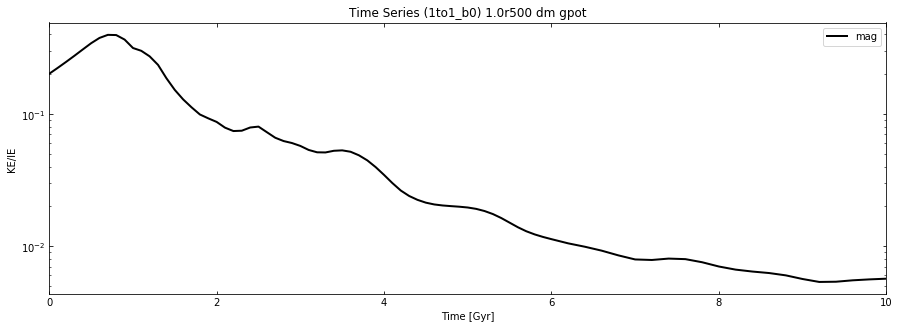

Finishing time series for mass, KE, IE, ME


In [6]:
f_mag = h5py.File(SIM_TYPE11_mag, 'r')
#f_no_mag = h5py.File(SIM_TYPE11_no_mag, 'r')
time = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/time"%"time_series_1.0r_500_part_gpm")[a:].in_units('Myr')
#time1to1nomag = m.yt.YTArray.from_hdf5(SIM_TYPE11_no_mag, dataset_name="/%s/time"%"time_series_1.0r_500_part_gpm")[a:].in_units('Myr')


mass_total_mag = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/mass_total"%"time_series_1.0r_500_part_gpm")[a:].in_units('Msun')
internal_energy_total_mag = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/internal_energy_total"%"time_series_1.0r_500_part_gpm")[a:].in_units('erg')
kinetic_energy_total_mag = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/kinetic_energy_total"%"time_series_1.0r_500_part_gpm")[a:].in_units('erg')
magnetic_energy_total_mag = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/magnetic_energy_total"%"time_series_1.0r_500_part_gpm")[a:].in_units('erg')

# mass_total_no_mag = m.yt.YTArray.from_hdf5(SIM_TYPE11_no_mag, dataset_name="/%s/mass_total"%"time_series_1.0r_500_part_gpm")[a:].in_units('Msun')
# internal_energy_total_no_mag = m.yt.YTArray.from_hdf5(SIM_TYPE11_no_mag, dataset_name="/%s/internal_energy_total"%"time_series_1.0r_500_part_gpm")[a:].in_units('erg')
# kinetic_energy_total_no_mag = m.yt.YTArray.from_hdf5(SIM_TYPE11_no_mag, dataset_name="/%s/kinetic_energy_total"%"time_series_1.0r_500_part_gpm")[a:].in_units('erg')

f_mag.close()
# f_no_mag.close()

# plot time series for mass, KE, IE, ME, GPE
#%matplotlib inline
print("Beginning time series for mass, KE, IE, ME")

plt.close('all')
f = plt.figure()
plt.figure(figsize=(15, 5))
plt.subplots_adjust(hspace=0.001)

#ax1 = plt.subplot(411)
ax2 = plt.subplot(111)

axes = [ax2]


#line_mass_total_mag, =ax1.plot(time, mass_total_mag, 'k', lw=2, label="M tot mag")
linekeiemag, =ax2.plot(time/1000, kinetic_energy_total_mag/internal_energy_total_mag, 'k', lw=2, label="mag")


#line_mass_total_no_mag, =ax1.plot(time1to1nomag, mass_total_no_mag, 'k--', lw=2, label="M tot no mag")
# time1to1nomag=list(time1to1nomag)
# del time1to1nomag[-1]
# time1to1nomag=np.array(time1to1nomag)
# linekeienomag, =ax2.plot(time1to1nomag/1000, kinetic_energy_total_no_mag/internal_energy_total_no_mag, 'k--', lw=2, label="no mag")

# ax2.legend(handles=[linekeiemag,linekeienomag], loc=1)
ax2.legend(handles=[linekeiemag], loc=1)


#ax1.set_ylabel('M [g]')
ax2.set_ylabel('KE/IE')

#ax2.set_ylim(1e49,2e50)

            
for ax in axes: 
    ax.set_yscale('log')

    ax.set_xlabel("Time [Gyr]")

    ax.set_xlim(0.0, 10.0)
    
    ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')


ax2.set_title('Time Series (%s) 1.0r500 dm gpot' % '1to1_b0')


#plt.savefig(IMG_DIR+SIM_TYPE+"_time_series_temp.png",bbox_inches='tight')
plt.show()

print("Finishing time series for mass, KE, IE, ME")